In [45]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime as dt

In [52]:
df = web.DataReader('ITC.NS', 'yahoo', start='2018-01-01', end='2022-01-18')

In [53]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-01,266.299988,261.250000,263.250000,262.299988,10461011.0,228.286194
2018-01-02,264.200012,260.450012,262.600006,260.750000,5688384.0,226.937225
2018-01-03,262.649994,260.600006,261.299988,261.149994,11018996.0,227.285339
2018-01-04,262.750000,260.600006,260.950012,261.549988,9368913.0,227.633453
2018-01-05,263.500000,261.899994,261.899994,262.899994,9211954.0,228.808411


In [54]:
df1 =  df.reset_index()['Open']

In [55]:
df1.head()

0    263.250000
1    262.600006
2    261.299988
3    260.950012
4    261.899994
Name: Open, dtype: float64

In [56]:
df1.shape

(1000,)

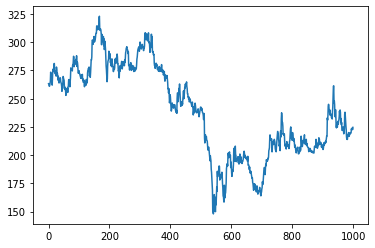

In [57]:
import matplotlib.pyplot as plt
plt.plot(df1)

### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [58]:
df1


0      263.250000
1      262.600006
2      261.299988
3      260.950012
4      261.899994
          ...    
995    222.500000
996    223.899994
997    223.949997
998    222.600006
999    224.600006
Name: Open, Length: 1000, dtype: float64

In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [60]:
df1.shape

(1000, 1)

In [61]:
##Splitting dataset into train and test
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [62]:
len(df1)

1000

In [63]:
len(train_data)

650

In [64]:
len(test_data)

350

In [65]:
training_size,test_size

(650, 350)

In [66]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [67]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy 
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [68]:
print(X_train)

[[0.6587596  0.65504429 0.64761349 ... 0.72020572 0.71106022 0.72020572]
 [0.65504429 0.64761349 0.64561306 ... 0.71106022 0.72020572 0.72477839]
 [0.64761349 0.64561306 0.65104307 ... 0.72020572 0.72477839 0.71163185]
 ...
 [0.08545296 0.01714776 0.01143184 ... 0.30637326 0.28608174 0.29665613]
 [0.01714776 0.01143184 0.08002286 ... 0.28608174 0.29665613 0.28922551]
 [0.01143184 0.08002286 0.04601316 ... 0.29665613 0.28922551 0.28008   ]]


In [69]:
print(X_train.shape), print(y_train.shape)

(549, 100)
(549,)


(None, None)

In [70]:
print(X_test.shape), print(ytest.shape)

(249, 100)
(249,)


(None, None)

In [71]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [72]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [73]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 5s 194ms/step - loss: 0.1079 - val_loss: 0.0056
Epoch 2/100
9/9 [==============================] - 1s 108ms/step - loss: 0.0224 - val_loss: 0.0082
Epoch 3/100
9/9 [==============================] - 1s 108ms/step - loss: 0.0129 - val_loss: 0.0043
Epoch 4/100
9/9 [==============================] - 1s 108ms/step - loss: 0.0103 - val_loss: 0.0050
Epoch 5/100
9/9 [==============================] - 1s 108ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 6/100
9/9 [==============================] - 1s 109ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 7/100
9/9 [==============================] - 1s 110ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 8/100
9/9 [==============================] - 1s 111ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 9/100
9/9 [==============================] - 1s 119ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 10/100
9/9 [==============================] - 1s 113ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 11/

In [76]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [77]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [78]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

255.8871326926866

In [79]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

214.2092634570591

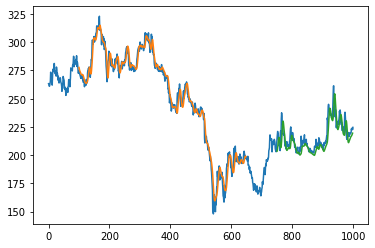

In [80]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [81]:
len(test_data)

350

In [82]:
350-100 ## here we see that since for predicting the open price of 19thJan 2022,we will use past 100 records to predict the price on jan 19th


250

In [89]:
x_input=test_data[250:].reshape(1,-1)
x_input.shape


(1, 100)

In [90]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [91]:
temp_input

[0.33380960172426477,
 0.3258073508022835,
 0.33152326923741116,
 0.3432409194730218,
 0.36010286141305003,
 0.3486710245427945,
 0.3529579633691403,
 0.36010286141305003,
 0.3595312346823397,
 0.36724775945695975,
 0.3603886747784052,
 0.37353530462279794,
 0.38239490842285095,
 0.3949699987545271,
 0.3941125586584616,
 0.4858530669858613,
 0.4744212301156058,
 0.49699909049076163,
 0.545870210554703,
 0.5544440882073945,
 0.5487281697722669,
 0.524721329788329,
 0.5250071431536839,
 0.5030008222912447,
 0.5252928693010454,
 0.4984280700995437,
 0.5030008222912447,
 0.5052871547780983,
 0.4961417376126901,
 0.4858530669858613,
 0.49585592424733493,
 0.4801371485507334,
 0.5178622451097742,
 0.5404401054849303,
 0.6016004152971989,
 0.645898783169439,
 0.6481851156562927,
 0.5598741932771673,
 0.5715918435127779,
 0.5527292952332575,
 0.49214061215169924,
 0.49214061215169924,
 0.5272934756405377,
 0.4978565305868271,
 0.44012571950483903,
 0.4352671539477829,
 0.4572734748102224,
 0.4

In [92]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.41384095]
101
1 day input [0.32580735 0.33152327 0.34324092 0.36010286 0.34867102 0.35295796
 0.36010286 0.35953123 0.36724776 0.36038867 0.3735353  0.38239491
 0.39497    0.39411256 0.48585307 0.47442123 0.49699909 0.54587021
 0.55444409 0.54872817 0.52472133 0.52500714 0.50300082 0.52529287
 0.49842807 0.50300082 0.50528715 0.49614174 0.48585307 0.49585592
 0.48013715 0.51786225 0.54044011 0.60160042 0.64589878 0.64818512
 0.55987419 0.57159184 0.5527293  0.49214061 0.49214061 0.52729348
 0.49785653 0.44012572 0.43526715 0.45727347 0.44584164 0.43926837
 0.46699052 0.46784796 0.4541297  0.47099164 0.4755644  0.49128317
 0.52043439 0.50300082 0.5258645  0.51386103 0.46384675 0.48270929
 0.45155756 0.46241777 0.42297796 0.42297796 0.42297796 0.42240634
 0.44012572 0.42097736 0.40525858 0.41726205 0.42869388 0.50414399
 0.51443266 0.4972849  0.46870531 0.44584164 0.42755072 0.39011143
 0.37725062 0.37725062 0.37667899 0.40011429 0.40240062 0.40011429
 0.41154613 0.39211204 0.39382675

In [93]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [94]:
day_new.shape

(100,)

In [95]:
import matplotlib.pyplot as plt

In [96]:
len(df1)

1000

In [97]:
1000-100

900

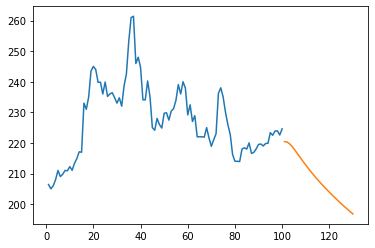

In [98]:
plt.plot(day_new,scaler.inverse_transform(df1[900:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))